<a href="https://colab.research.google.com/github/Nickil21/ml-planetary-albedo/blob/main/Task_2_Machine_Learning_Model_for_the_Planetary_Albedo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 2: Predicting Mercury’s elemental composition from Albedo with MESSENGER Data
---

*author: [Nickil Maveli](https://nickil21.github.io/)*

In this task, we are asked to find the relationship between albedo and chemical compositions in the top half of the planet and leverage that information to predict the chemical composition for the bottom half of the planet using albedo.

At a high level, we can design our approach in the following manner:

1.   Fill the missing pixel values of the chemical composition maps using a strong heuristic that relies heavily on the neighbouring elements.
2.   Train a set of linear/tree-based/Neural Network models using multi-output regression technique that learns to predict chemical composition values for a given albedo map (top-half).
3.   Predict chemical composition values for a given albedo map (bottom-half).
4.   Once we have the predicted chemical composition values, we can use the following strategy:
    * Retrieve the non-zero pixel values from the chemical composition maps — this means that there exists a mapping of some sort. We treat these as inputs. Next, obtain the corresponding albedo mapping. We treat these as gold-standard output.
    * Train a simple linear regression model that predicts the albedo value given chemical composition inputs. In order to check if the predicted chemical composition values are accurate enough (from step 3), we predict the albedo (bottom-half) given the predicted chemical composition values. We visualize both the gold-standard and the predicted albedo (bottom-half) and find that the model has successfully developed the understanding between identifying the correct chemical composition values given the albedo, and even vice-versa is true.




In [ ]:
# Import the necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import KFold
from sklearn.multioutput import MultiOutputRegressor

from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor

from keras.models import Sequential
from keras.layers import Dense, Dropout

plt.style.use('fivethirtyeight') # For better style
%matplotlib inline

Read the datasets provided at the [github link](https://github.com/ML4SCI/ML4SCI_GSoC/tree/main/Messenger/Mercury).

In [ ]:
BASE_URL = "https://raw.githubusercontent.com/ML4SCI/ML4SCI_GSoC/main/Messenger/Mercury/"

mercury_top_half = pd.read_csv(BASE_URL + "mercury-albedo-top-half.png.csv", header=None)
mercury_bottom_half = pd.read_csv(BASE_URL + "mercury-albedo-resized-bottom-half.png.csv", header=None)

TOP_SHAPE = mercury_top_half.shape
BOTTOM_SHAPE = mercury_bottom_half.shape

# alsimap_smooth (Al to Si element ratio)
al_si_map =  pd.read_csv(BASE_URL + "alsimap_smooth_032015.png.csv", header=None) 
# mgsimap_smooth (Mg to Si element ratio)
mg_si_map =  pd.read_csv(BASE_URL + "mgsimap_smooth_032015.png.csv", header=None) 
# casimap_smooth (Ca to Si element ratio)
ca_si_map =  pd.read_csv(BASE_URL + "casimap_smooth_032015.png.csv", header=None) 
# ssimap_smooth (S to Si element ratio)
s_si_map  =  pd.read_csv(BASE_URL + "ssimap_smooth_032015.png.csv", header=None) 
# fesimap_smooth (Fe to Si element ratio)
fe_si_map =  pd.read_csv(BASE_URL + "fesimap_smooth_032015.png.csv", header=None) 

Flattening the 2-D array (dataframe) to 1-D array so as to aid us in the modeling process.

In [ ]:
chemical_composition = pd.DataFrame({'Al': al_si_map.values.ravel(), 
                                     'Mg': mg_si_map.values.ravel(), 
                                     'Ca': ca_si_map.values.ravel(),
                                     'S': s_si_map.values.ravel(), 
                                     'Fe': fe_si_map.values.ravel()})

albedo_top = pd.DataFrame({'mercury_top': mercury_top_half.values.ravel()})
albedo_bottom = pd.DataFrame({'mercury_bottom': mercury_bottom_half.values.ravel()})

Let us compute the non-zero chemical composition values which would come handy later. 

In [ ]:
non_zero_chemical_composition = chemical_composition[(chemical_composition != 0).all(axis=1)]

Plotting the albedo map to confirm if we are reading the file correctly as a sanity check.

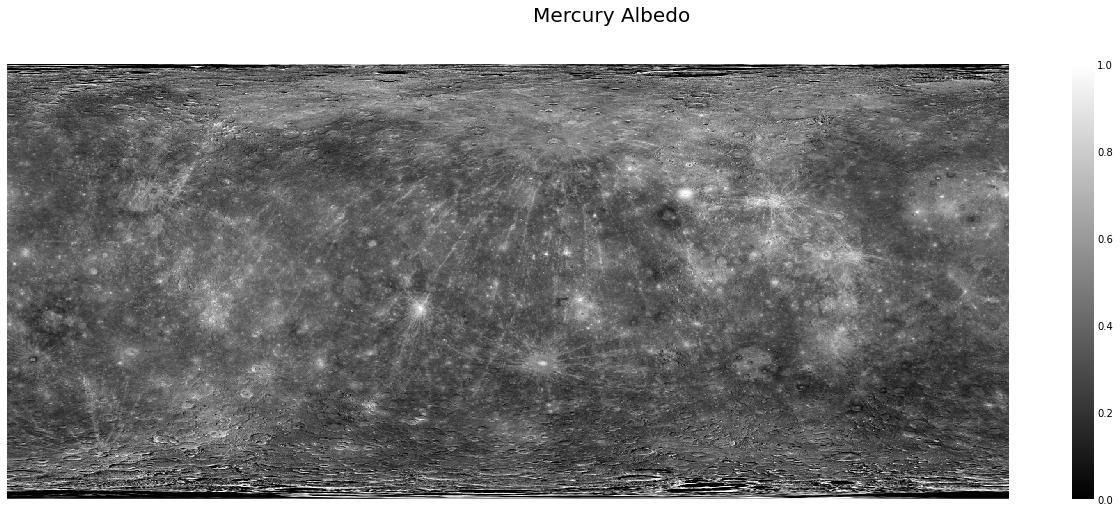

In [ ]:
albedo_map = mercury_top_half.append(mercury_bottom_half)

fig, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(albedo_map, cmap="gray", xticklabels=False, yticklabels=False, ax=ax)
plt.suptitle("Mercury Albedo", fontsize=20)
plt.show()

Plotting the Smoothed maps.

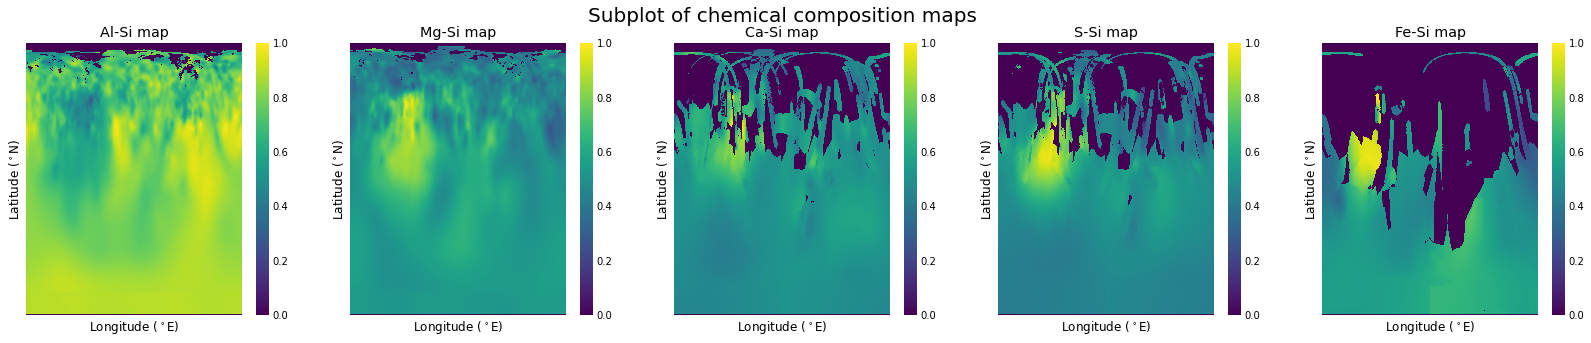

In [ ]:
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))
ax1.get_shared_y_axes().join(ax2,ax3,ax4,ax5)

g1 = sns.heatmap(al_si_map, cmap="viridis", xticklabels=False, yticklabels=False, ax=ax1)
g1.set_xlabel("Longitude ($^\circ$E)")
g1.set_ylabel("Latitude ($^\circ$N)")
g1.set_title("Al-Si map")

g2 = sns.heatmap(mg_si_map, cmap="viridis", xticklabels=False, yticklabels=False, ax=ax2)
g2.set_xlabel("Longitude ($^\circ$E)")
g2.set_ylabel("Latitude ($^\circ$N)")
g2.set_title("Mg-Si map")

g3 = sns.heatmap(ca_si_map, cmap="viridis", xticklabels=False, yticklabels=False, ax=ax3)
g3.set_xlabel("Longitude ($^\circ$E)")
g3.set_ylabel("Latitude ($^\circ$N)")
g3.set_title("Ca-Si map")

g4 = sns.heatmap(s_si_map, cmap="viridis", xticklabels=False, yticklabels=False, ax=ax4)
g4.set_xlabel("Longitude ($^\circ$E)")
g4.set_ylabel("Latitude ($^\circ$N)")
g4.set_title("S-Si map")

g5 = sns.heatmap(fe_si_map, cmap="viridis", xticklabels=False, yticklabels=False, ax=ax5)
g5.set_xlabel("Longitude ($^\circ$E)")
g5.set_ylabel("Latitude ($^\circ$N)")
g5.set_title("Fe-Si map")

plt.suptitle("Subplot of chemical composition maps", fontsize=20)
plt.show()

In the above figure, the dark purple areas are unmapped for these elements. Since Mg-Si and Al-Si maps incorporate both quiet-Sun and solar flare analyses, they have near-global coverage. On the other hand, considerable coverage gaps are present in the S-Si, Ca-Si, and Fe-Si maps as these elements can be detected only during flares.

We explore the dataset by performing an Exploratory Data Analysis.

In [ ]:
df = pd.concat([chemical_composition, albedo_top], axis=1)

Let us generate the descriptive statistics.

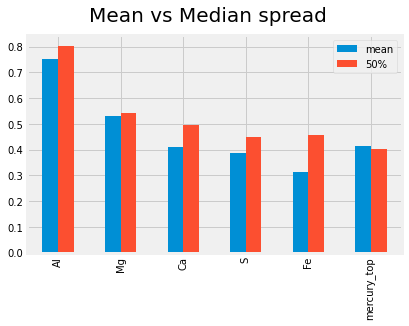

In [ ]:
df.describe().loc[['mean', '50%']].T.plot.bar();
plt.suptitle("Mean vs Median spread", fontsize=20);

The median and mean for mercury_top are somewhat similar, so the training set isn't skewed by any outliers.

Plotting bivariate distributions using kernel density estimation.

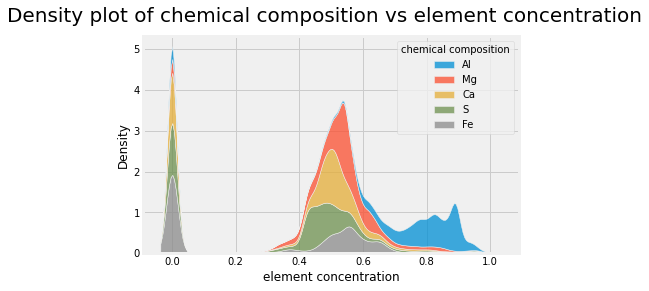

In [ ]:
stacked_chemical_composition = chemical_composition.stack().to_frame(name="element concentration").reset_index(level=1).rename(columns={"level_1": "chemical composition"})
sns.kdeplot(data=stacked_chemical_composition, x="element concentration", hue="chemical composition", multiple="stack");
plt.suptitle("Density plot of chemical composition vs element concentration", fontsize=20);

Let us perform a scatter plot.

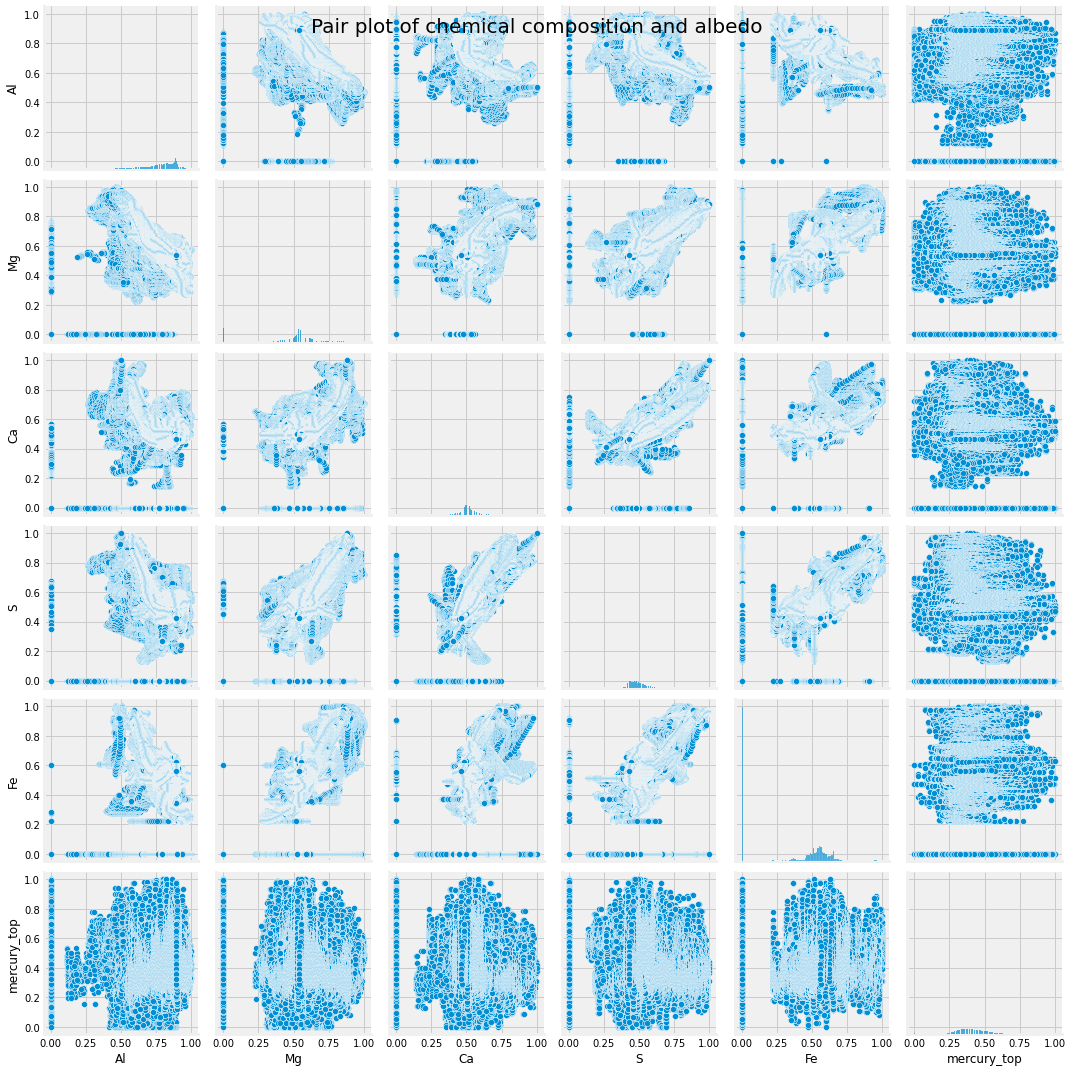

In [ ]:
cols = df.columns.tolist()
sns.pairplot(df[cols])
plt.tight_layout()
plt.suptitle("Pair plot of chemical composition and albedo", fontsize=20);

From these plots, it is clear that the distribution is not very intuitive for us to make any sort of a clear observation. Moreover, the relationship between the independent variable and the dependent variables does provide a hint that there are more prototypical element concentration around 0.4 to 0.6. There are also not many outliers observed.

Let us study the effect of correlation using a heatmap.

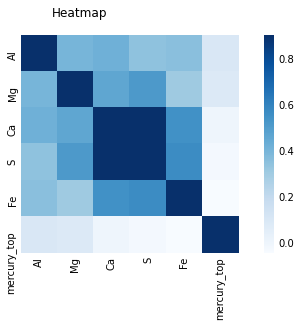

In [ ]:
corr = df.corr()
plt.subplots(figsize=(8, 4))
sns.heatmap(corr, vmax=0.9, cmap="Blues", square=True)
plt.suptitle("Heatmap")
plt.show()

We can find an interesting pattern here — "Ca" and "S" appear to be the most correlated chemical. Well, this is unsurprising and expected as when we had visualized the chemical maps, we found their element concentration to be similar. 

Missing values of Chemical composition.

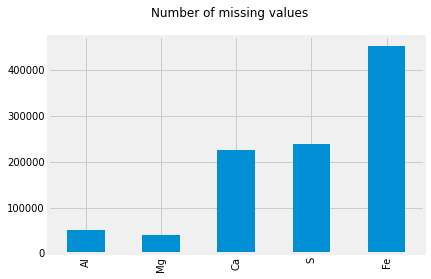

In [ ]:
(chemical_composition == 0).sum(axis=0).plot.bar();
plt.suptitle("Number of missing values");

As we can see, Iron and Alumninium have the largest and the smallest number of missing values respectively.

# Imputation for missing values

Since the element concentration at any given location is closely related to it's neighbouring locations, we can make use of interpolation techniques like [`fillna`](https://pandas-docs.github.io/pandas-docs-travis/user_guide/missing_data.html#filling-missing-values-fillna) to complete the missing parts. We experiment with backward and forward filling techniques. 

In [ ]:
chemical_composition = chemical_composition.replace(0, np.nan).fillna(method='bfill').fillna(method='ffill')

We verify if all the zeros in the dataset has been replaced by a non-zero value.

In [ ]:
chemical_composition.isnull().sum()

Al    0
Mg    0
Ca    0
S     0
Fe    0
dtype: int64

Plotting the smoothed maps after imputing the missing values.

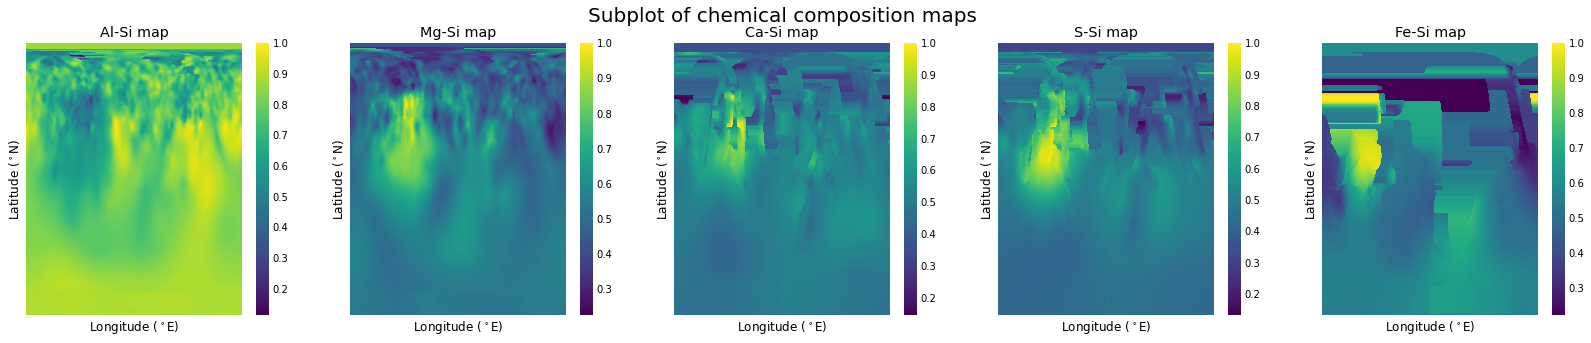

In [ ]:
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))
ax1.get_shared_y_axes().join(ax2,ax3,ax4,ax5)

g1 = sns.heatmap(chemical_composition['Al'].values.reshape(TOP_SHAPE), cmap="viridis", xticklabels=False, yticklabels=False, ax=ax1)
g1.set_xlabel("Longitude ($^\circ$E)")
g1.set_ylabel("Latitude ($^\circ$N)")
g1.set_title("Al-Si map")

g2 = sns.heatmap(chemical_composition['Mg'].values.reshape(TOP_SHAPE), cmap="viridis", xticklabels=False, yticklabels=False, ax=ax2)
g2.set_xlabel("Longitude ($^\circ$E)")
g2.set_ylabel("Latitude ($^\circ$N)")
g2.set_title("Mg-Si map")

g3 = sns.heatmap(chemical_composition['Ca'].values.reshape(TOP_SHAPE), cmap="viridis", xticklabels=False, yticklabels=False, ax=ax3)
g3.set_xlabel("Longitude ($^\circ$E)")
g3.set_ylabel("Latitude ($^\circ$N)")
g3.set_title("Ca-Si map")

g4 = sns.heatmap(chemical_composition['S'].values.reshape(TOP_SHAPE), cmap="viridis", xticklabels=False, yticklabels=False, ax=ax4)
g4.set_xlabel("Longitude ($^\circ$E)")
g4.set_ylabel("Latitude ($^\circ$N)")
g4.set_title("S-Si map")

g5 = sns.heatmap(chemical_composition['Fe'].values.reshape(TOP_SHAPE), cmap="viridis", xticklabels=False, yticklabels=False, ax=ax5)
g5.set_xlabel("Longitude ($^\circ$E)")
g5.set_ylabel("Latitude ($^\circ$N)")
g5.set_title("Fe-Si map")

plt.suptitle("Subplot of chemical composition maps", fontsize=20)
plt.show()

As we can see, the missing regions of the image have been merged with their nearest surrounding layers.

We begin the modeling process. We treat the identification of the chemical composition maps as a multi-output regression problem. In multi-output regression, two or more outputs are required for each input sample, and the outputs are required simultaneously. The assumption is that the outputs are a function of the input(s).

In [ ]:
X = albedo_top
y = chemical_composition.values
X_test = albedo_bottom

We experiment with the following models:


1. Linear Regression
2. Extra Trees
3. Random Forest
4. XGBoost
5. LightGBM
6. Neural Network

We define the hyperparameters for each of our chosen models:

In [ ]:
# NN model
def nn_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(128, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_outputs))
    model.compile(loss='mae', optimizer='adam')
    return model

In [ ]:
nn_params = {'n_inputs': X.shape[1],
             'n_outputs': y.shape[1]
}

et_params = {
    'n_jobs': -1,
    'n_estimators': 100,
    'max_depth': 12,
    'min_samples_leaf': 2,
}

rf_params = {
    'n_jobs': -1,
    'n_estimators': 100,
    'max_depth': 8,
    'min_samples_leaf': 2,
}

xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.7,
    'silent': 1,
    'subsample': 0.7,
    'learning_rate': 0.1,
    'objective': 'reg:linear',
    'max_depth': 7,
    'num_parallel_tree': 1,
    'min_child_weight': 1,
    'eval_metric': 'mae',
    'n_estimators': 350
}

lgb_params = {'objective': 'regression', 
              'num_leaves': 127,
              'max_depth': 12,
              'learning_rate': 0.1, 
              'n_estimators': 500,
              'max_bin': 200, 
              'bagging_fraction': 0.7,
              'bagging_freq': 5, 
              'bagging_seed': 7,
              'feature_fraction': 0.7,
              'feature_fraction_seed': 7,
              'verbose': -1,
              # 'min_data_in_leaf': 2,
              # 'min_sum_hessian_in_leaf': 11
}

In [ ]:
class SklearnWrapper(object):
    """
    Customized Wrapper to train all models
    """
    def __init__(self, clf, multi_output=False, params=None):
        if multi_output:
            self.clf = MultiOutputRegressor(clf(**params))
        else:
            self.clf = clf(**params)

    def train(self, X, y):
        self.clf.fit(X, y)

    def train_nn(self, x_train, y_train, x_test, y_test):
        self.clf.fit(x_train, y_train, verbose=0, epochs=2, shuffle=False, 
                     batch_size=32, validation_data=(x_test, y_test))

    def predict(self, x):
        return self.clf.predict(x)


def get_oof(clf, is_nn=False):
    """
    Get out-of-fold predictions
    """
    oof_train = np.zeros((ntrain, 5))
    oof_test = np.zeros((ntest, 5))
    oof_test_skf = np.empty((NFOLDS, ntest, 5))

    for i, (train_index, test_index) in enumerate(kf.split(oof_train)):
        print("Fitting fold ({}/{})".format(i+1, NFOLDS))
        x_tr = X.loc[train_index]
        y_tr = y[train_index]
        x_te = X.loc[test_index]
        y_te = y[test_index]
        
        if is_nn:
            clf.train_nn(x_tr, y_tr, x_te, y_te)
        else:
            clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        print("[Fold {}] MAE : {:.4f}".format(i+1, mean_absolute_error(y_te, oof_train[test_index])))
        oof_test_skf[i, :] = clf.predict(X_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train, oof_test

Training all the models sequentially.

In [ ]:
SEED = 2021
NFOLDS = 2 # 5
ntrain = X.shape[0]
ntest = X_test.shape[0]

kf = KFold(n_splits=NFOLDS, shuffle=False)

nn = SklearnWrapper(clf=nn_model, params=nn_params)
lg = SklearnWrapper(clf=LGBMRegressor, multi_output=True, params=lgb_params)
xg = SklearnWrapper(clf=XGBRegressor, multi_output=True, params=xgb_params)
lr = SklearnWrapper(clf=LinearRegression, params={})
et = SklearnWrapper(clf=ExtraTreesRegressor, params=et_params)
rf = SklearnWrapper(clf=RandomForestRegressor, params=rf_params)

print("Training Neural Network model ...")
nn_oof_train, nn_oof_test = get_oof(nn, is_nn=True)
print("Training LightGBM model ...")
lg_oof_train, lg_oof_test = get_oof(lg)
print("Training XGBoost model ...")
xg_oof_train, xg_oof_test = get_oof(xg)
print("Training Linear Regression model ...")
lr_oof_train, lr_oof_test = get_oof(lr)
print("Training Extra Trees model ...")
et_oof_train, et_oof_test = get_oof(et)
print("Training Random Forest model ...")
rf_oof_train, rf_oof_test = get_oof(rf)

Training Neural Network model ...
Fitting fold (1/2)
[Fold 1] MAE : 0.1223
Fitting fold (2/2)
[Fold 2] MAE : 0.0555
Training LightGBM model ...
Fitting fold (1/2)
[Fold 1] MAE : 0.1137
Fitting fold (2/2)
[Fold 2] MAE : 0.0594
Training XGBoost model ...
Fitting fold (1/2)


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[Fold 1] MAE : 0.1143
Fitting fold (2/2)


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[Fold 2] MAE : 0.0593
Training Linear Regression model ...
Fitting fold (1/2)
[Fold 1] MAE : 0.1129
Fitting fold (2/2)
[Fold 2] MAE : 0.0576
Training Extra Trees model ...
Fitting fold (1/2)
[Fold 1] MAE : 0.1143
Fitting fold (2/2)
[Fold 2] MAE : 0.0593
Training Random Forest model ...
Fitting fold (1/2)
[Fold 1] MAE : 0.1139
Fitting fold (2/2)
[Fold 2] MAE : 0.0593


In [ ]:
print("MAE for NN-CV : {:.4f}".format(mean_absolute_error(y, nn_oof_train)))
print("MAE for LGB-CV: {:.4f}".format(mean_absolute_error(y, lg_oof_train)))
print("MAE for XGB-CV: {:.4f}".format(mean_absolute_error(y, xg_oof_train)))
print("MAE for LR-CV : {:.4f}".format(mean_absolute_error(y, lr_oof_train)))
print("MAE for ET-CV : {:.4f}".format(mean_absolute_error(y, et_oof_train)))
print("MAE for RF-CV : {:.4f}".format(mean_absolute_error(y, rf_oof_train)))

MAE for NN-CV : 0.0889
MAE for LGB-CV: 0.0865
MAE for XGB-CV: 0.0868
MAE for LR-CV : 0.0853
MAE for ET-CV : 0.0868
MAE for RF-CV : 0.0866


Let us take a simple average of our base models on the out of fold predictions for the training set.

In [ ]:
blend_train = (nn_oof_train + lg_oof_train + xg_oof_train + lr_oof_train + et_oof_train + rf_oof_train) / 6

In [ ]:
print("MAE for Blended-CV: {:.4f}".format(mean_absolute_error(y, blend_train)))

MAE for Blended-CV: 0.0857


Let us take a simple average of our base models on the out of fold predictions for the test set.

In [ ]:
blend_test = (nn_oof_test + lg_oof_test + xg_oof_test + lr_oof_test + et_oof_test + rf_oof_test) / 6

In [ ]:
predicted_chemical_composition = pd.DataFrame(blend_test, columns=['Al', 'Mg', 'Ca', 'S', 'Fe'])

Description Statistics.

In [ ]:
predicted_chemical_composition.describe()

,Al,Mg,Ca,S,Fe
count,1.036800e+06,1.036800e+06,1.036800e+06,1.036800e+06,1.036800e+06
mean,7.966782e-01,5.495308e-01,5.102759e-01,4.937557e-01,5.471044e-01
std,6.255236e-03,5.588514e-03,7.849935e-03,1.078987e-02,1.490258e-02
min,7.644714e-01,5.099635e-01,4.583759e-01,4.291920e-01,5.311342e-01
25%,7.971047e-01,5.473096e-01,5.080696e-01,4.868501e-01,5.405478e-01
50%,7.988853e-01,5.497981e-01,5.102964e-01,4.949853e-01,5.424911e-01
75%,7.999286e-01,5.526857e-01,5.157922e-01,5.029654e-01,5.450783e-01
max,8.376275e-01,5.606250e-01,5.207238e-01,5.107020e-01,6.050306e-01


We do a sanity check to see if the obtained chemical composition prediction for the bottom half of the planet using the albedo is indeed accurate. We treat the values of chemical maps corresponding to non-zero values that had measurements to be the input set. The gold labels would be the corresponding top half of the planet using the albedo.

In [ ]:
X = non_zero_chemical_composition
y = albedo_top.loc[non_zero_chemical_composition.index].values
X_test = predicted_chemical_composition

Fitting a simple Linear Regression model.

In [ ]:
clf = LinearRegression()

clf.fit(X, y)
y_out = clf.predict(X_test)

Normalizing the predictions.

In [ ]:
output = (y_out - y_out.min()) / (y_out.max() - y_out.min())

Plotting the gold-standard albedo map (bottom-half) and the predicted albedo map (bottom-half)

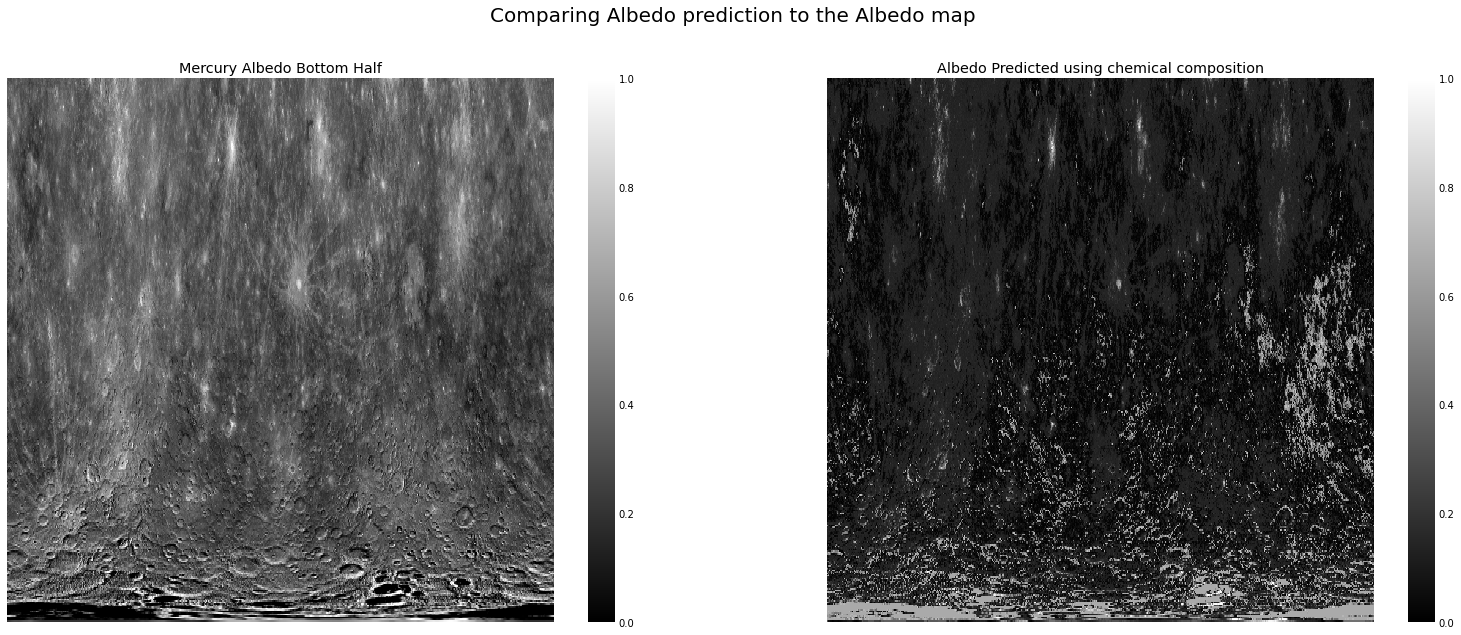

In [ ]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(24, 10))

g1 = sns.heatmap(mercury_bottom_half, cmap="gray", xticklabels=False, yticklabels=False, ax=ax1)
g1.set_title("Mercury Albedo Bottom Half")

g2 = sns.heatmap(output.reshape(BOTTOM_SHAPE), cmap="gray", xticklabels=False, yticklabels=False, ax=ax2)
g2.set_title("Albedo Predicted using chemical composition")

plt.suptitle("Comparing Albedo prediction to the Albedo map", fontsize=20)
plt.show();

Let us evaluate on 3 different regression metrics.

In [ ]:
print('MAE :', mean_absolute_error(mercury_bottom_half.values.ravel(), output))
print('MSE :', mean_squared_error(mercury_bottom_half.values.ravel(), output))
print('RMSE:', np.sqrt(mean_squared_error(mercury_bottom_half.values.ravel(), output)))

MAE : 0.2785419413635843
MSE : 0.08575040390377292
RMSE: 0.2928316989394641


Let us plot to get a visual intuition.

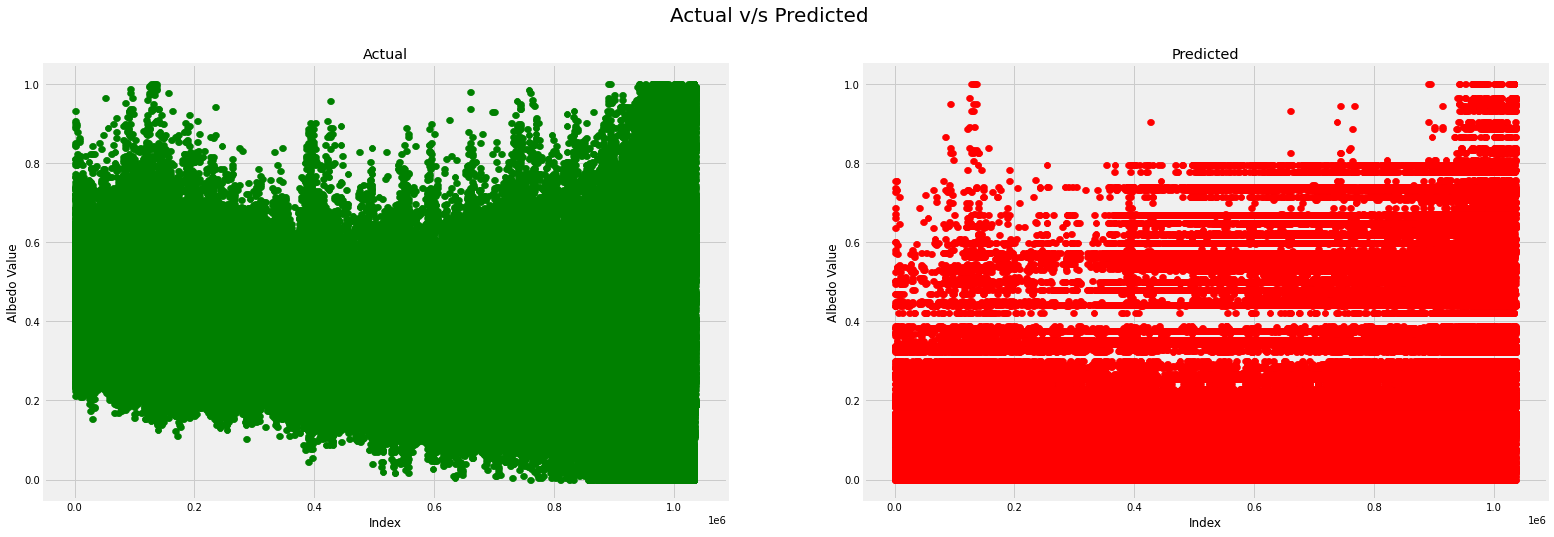

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))
ax1.scatter(np.arange(mercury_bottom_half.values.ravel().shape[0]), mercury_bottom_half.values.ravel(), c='g')
ax1.set_title("Actual")
ax1.set_xlabel("Index")
ax1.set_ylabel("Albedo Value")
ax2.scatter(np.arange(output.shape[0]), output, c='r')
ax2.set_title("Predicted")
ax2.set_xlabel("Index")
ax2.set_ylabel("Albedo Value")
plt.suptitle("Actual v/s Predicted", fontsize=20)
plt.show();

Woow! The results look really accurate considering we relied on a very naive approach for completing the missing pixels for the chemical composition maps.

A couple of approaches I would have performed to fill the missing parts of the images are:

1. [Inpainting](https://en.wikipedia.org/wiki/Inpainting)
2. Using K Nearest Neighbour algorithm to calculate the nearest element in the dataset having the smallest euclidean distance compared to the missing element.